<a href="https://colab.research.google.com/github/rigonzal/ANN/blob/master/Approach2/Pregunta_1_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF-395 Redes Neuronales Artificiales II-2018

## Tarea 2 - Redes Convolucionales y sus aplicaciones


26/11/2018

* Rodrigo González Smith 201303026-2
* Ignacio Valenzuela Albornoz 2014073055-1

## Introducción Trabajo

En la presente tarea se trabaja con redes neuronales convolucionales, por medio de las librerías tipicas tendrémos que probar y experimentar en 3 secciones. La primera orientada a las redes convolucionales sobre clasificación de imágenes, donde se deberá comprender las arquitecturas,  parámetros y cambios en el dataset que pueden finalmente afectar a los resultados obtenidos. La segunda sección se verá principalmente *Trasnfer learning*, es decir poder pasar conocimiento desde una red neuronal a otra. Finalmente en la tercera sección <---insertar--->. Todo lo anterior hará reflexionar y obtener conocimiento para poder trabajar con arquitecturas convolucionales, como también saber que aspectos son utiles para cada caso que se nos presente.

## Introducción Parte 1



Débido al tema del trabajo usaremos **Keras** para la creación de las redes y su posterior entrenamiento/validación. Como también las librerías comunes de trabajo de Python que nos facilitarán nuestras tareas experimentales:

In [0]:
#Correr solo en Colab
!pip install -q keras

In [2]:
import numpy as np   
import os   
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
import os
import h5py

%matplotlib inline

Using TensorFlow backend.


## 1. Convolutional Neural Networks (CNN) en CIFAR

Para esta primera parte del informe se trabajaran con los datos de CIFAR10, los cuales correspondes a imágenes las cuales tendremos que clasificar en sus cateogrías correspondientes. De esta manera usaremos CNN, las cuales son adecuadas y efectivas para este tipo de tareas.   

### 1.a) Exploración del Dataset

El data set cuenta con 60.000 imágenes con resolución 32x32, las cuales se clasifican en 10 categorías.  Las proporciones de los datos serán 40.000, 10.000 y 10.000 respectivamente para entrenamiento, validación y test.

In [3]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']  
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 64s 0us/step


Extraemos algunas imágenes para visualizar con sus respectivas etiquetas:

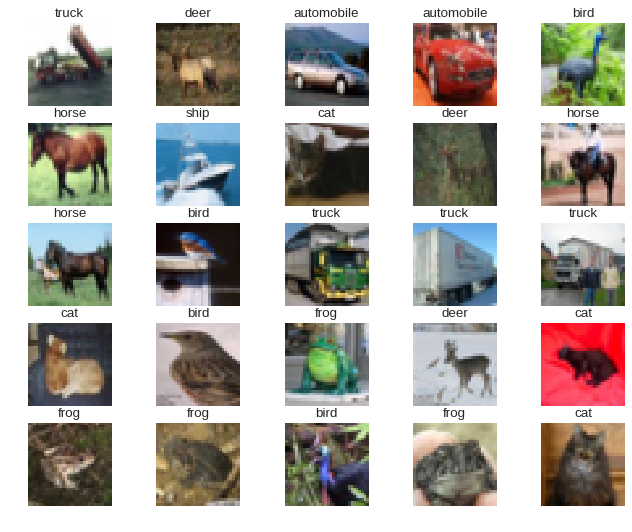

In [4]:
import random
# Aumentamos el tamaño del plot
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
rand =  random.randint(0, 5)
for i in range(25):  
  plt.subplot(5,5,i+1)
  plt.title(label_names[y_train[i+rand][0]])
  plt.axis('off')
  _=plt.imshow(x_train[i+rand])

La mala resolución se debe a los poco pixeles de la muestra, sin embargo para nuestros fines sera suficiente en el trabajo. Siguiente a esto separamos  los datos según como dijimos previamente:

In [5]:
X = x_train.copy()
n_train = len(x_train)
x_val = x_train[int(0.8*n_train):n_train]
y_val = y_train[int(0.8*n_train):n_train]
x_train = x_train[:int(0.8*n_train)]
y_train = y_train[:int(0.8*n_train)]

print("Partición del dataset: ")
print("[Training]: " + str(len(x_train)))
print("[Validation]: " + str(len(x_val)))
print("[Test]: " + str(len(x_test)))

Partición del dataset: 
[Training]: 40000
[Validation]: 10000
[Test]: 10000


### 1.b) Preparación de dataset

Normalizamos los datos para que estén en el rango $x \in [0,1]$. En este caso, dado que son positivos al ser RGB. 

In [6]:
x_train_norm = x_train.copy()/255
x_val_norm = x_val.copy()/255
x_test_norm = x_test.copy()/255

num_classes = len(label_names)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Dimensión de cada fila: " + str(x_train_norm[0].shape))

Dimensión de cada fila: (32, 32, 3)


En donde la tercera columna corresponde a la codificación RGB o *channels* la cual nos agrega la dimensión necesaria para la definición del color.    Por lo cual se estará usando el orden de TensorFlow para el ordenamiento de las dimensiones de las imagenes.

### 1.c) Definición CNN

Se define la red neuronal convolucional inicial a usar para la clasificación.  Se muestra un esquema respecto a la estructura interior de la red, con las dimensiones y sus cambios a medida que se avanza en ella. Notamos que antes de entrar a la capa densa de 512 neurona, se debe hacer un *flatten* del output de la anterior, con tal de que sea un vector de pesos el Input a esa capa escondida.



In [7]:
model_1_c = Sequential()
model_1_c.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_c.add(Activation('relu'))
model_1_c.add(MaxPooling2D(pool_size=(2, 2)))
model_1_c.add(Conv2D(64, (3, 3), padding='same'))
model_1_c.add(Activation('relu'))
model_1_c.add(MaxPooling2D(pool_size=(2, 2)))
model_1_c.add(Flatten())
model_1_c.add(Dense(512))
model_1_c.add(Activation('relu'))
model_1_c.add(Dense(10))
model_1_c.add(Activation('softmax'))
model_1_c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

Se puede apreciar la reducción dimensional que provocan las capas de *pooling*.

### 1.d) Entrenamiento CNN

Para entrenar se usara el algoritmo del gradiente estocástico, con un momentum de 0.9. Además la tasa de apredizaje será cambiada manualmente, y estará en el rango $\eta \in [{10^{-3},10^{-5}}] $,  se usará un *learning rate scheduler* de Keras .Esta se reduce a la mitad cada 10 épocas, el entrenamiento inicial se hizo con 25.

In [8]:
def step_decay(epoch):
    initial_lrate = 0.001
    lrate = initial_lrate * math.pow(0.5, math.floor((epoch)/10))
    lrate = max(lrate,0.00001)
    return lrate
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
lrate = LearningRateScheduler(step_decay)
batch_size = 1000
epochs = 25
model_1_c.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=["accuracy"] )
history_1_c = model_1_c.fit(x_train_norm, y_train,batch_size=batch_size,epochs=epochs, validation_data=(x_val_norm,y_val), shuffle=True, callbacks=[lrate])

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
40000/40000 [==============================] - 9s 221us/step - loss: 2.2946 - acc: 0.1070 - val_loss: 2.2826 - val_acc: 0.1301
Epoch 2/25
40000/40000 [==============================] - 4s 104us/step - loss: 2.2706 - acc: 0.1524 - val_loss: 2.2580 - val_acc: 0.1768
Epoch 3/25
40000/40000 [==============================] - 4s 103us/step - loss: 2.2436 - acc: 0.1907 - val_loss: 2.2275 - val_acc: 0.2209
Epoch 4/25
40000/40000 [==============================] - 4s 104us/step - loss: 2.2073 - acc: 0.2308 - val_loss: 2.1855 - val_acc: 0.2434
Epoch 5/25
40000/40000 [==============================] - 4s 105us/step - loss: 2.1590 - acc: 0.2488 - val_loss: 2.1338 - val_acc: 0.2579
Epoch 6/25
40000/40000 [==============================] - 4s 104us/step - loss: 2.1041 - acc: 0.2704 - val_loss: 2.0809 - val_acc: 0.2757
Epoch 7/25
40000/40000 [==============================] - 4s 105us/step - loss: 2.0523 - acc: 0.2868 - val_loss: 2.0351 - 

Con la red ya entrenada, se grafica la perdida y precisión de training contra la validación, para de esta manera tener una visión más general de la tendencia en el proceso de entrenamiento:

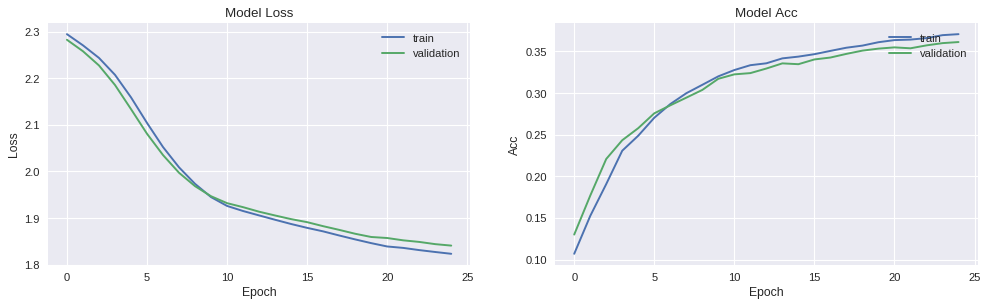

In [9]:
plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(history_1_c.history['loss'])
plt.plot(history_1_c.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.subplot(1,2,2)
plt.plot(history_1_c.history['acc'])
plt.plot(history_1_c.history['val_acc'])
plt.title('Model Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Notamos  que el error podría haber seguido disminuyendo si se entrenaban algunas épocas más, sin embargo  en la validación ya estaba mostrando tendencias a separarse. Por lo cual puede que se empezara a "estancar" después de algunas épocas más o seguir cercano al *loss* de entrenamiento. Por otro lado el *accurcay* logrado es bajo, podemos suponer a priori debido a factores como la arquitectura de la red, épocas y el optimizador de la red.

### 1.e)  RMSProp

Ahora entrenaremos la red con RMSProp,  el cual reduce la tasa de aprendizaje o *learning rate* a medida que avanzan las épocas de entrenamiento,  adaptandolo según la acumulación de valores anteriores de los gradientes descendientes. Donde, por defecto se usará $\gamma  = 0.9$, el cual controla el largo de la escala de los promedios moviles. La idea de usar estos promedios moviles, es que la división de la tasa de aprendizaje se haga por números similares, entre *batches* adyacentes. Calcularemos el error de training, validación y test:


In [10]:
#función necesaria para obtener también el error de test
def get_metrics(model, data, epochs, batchs, lrate=None,verbos=1):
  history = list()
  history_test = list()
  for i in range(epochs):
    print("Epoch " + str(i+1) +"/" + str(epochs))
    if lrate == None:
      his = model.fit(data[0], data[1],batch_size=batchs,epochs=1,verbose=verbos , validation_data=(data[2],data[3]), shuffle=True)
    else:
      his = model.fit(data[0], data[1],batch_size=batchs,epochs=1,verbose=verbos ,validation_data=(data[2],data[3]), shuffle=True,callbacks=[lrate])
    history.append(his)
    loss, acc = model.evaluate(data[4],data[5],verbose=verbos)
    history_test.append([loss,acc])
    print("[TEST]: loss=" + str(loss) + ", acc= "+ str(acc))
  return history,history_test



#se define el modelo
model_1_e = Sequential()
model_1_e.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_e.add(Activation('relu'))
model_1_e.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e.add(Conv2D(64, (3, 3), padding='same'))
model_1_e.add(Activation('relu'))
model_1_e.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e.add(Flatten())
model_1_e.add(Dense(512))
model_1_e.add(Activation('relu'))
model_1_e.add(Dense(10))
model_1_e.add(Activation('softmax'))

#se agrega optimizador
opt = rmsprop(lr=0.001, decay=1e-6)
batch_size = 1000
epochs = 25
model_1_e.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'] )

#se agrega a una lista todos los datos para evitar funciones engorrosas, lo cual servirá para futuras ejecuciones
data = [x_train_norm, y_train, x_val_norm, y_val, x_test_norm, y_test]


history_1_e, history_1_e_test= get_metrics(model_1_e, data, epochs, batch_size,verbos=2)

Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 2.1691 - acc: 0.2401 - val_loss: 1.8564 - val_acc: 0.3343
[TEST]: loss=1.8514345088958741, acc= 0.3385
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 1.7551 - acc: 0.3822 - val_loss: 1.5421 - val_acc: 0.4764
[TEST]: loss=1.532294218635559, acc= 0.4647
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 1.5787 - acc: 0.4470 - val_loss: 1.6558 - val_acc: 0.4171
[TEST]: loss=1.6388483757019043, acc= 0.4226
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 1.4353 - acc: 0.4946 - val_loss: 1.4816 - val_acc: 0.5015
[TEST]: loss=1.4727156719207763, acc= 0.4906
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
 - 4s - loss: 1.3397 - acc: 0.5330 - val_loss: 1.3001 - val_acc: 0.5455
[TEST]: loss=1.2811020231246948, acc= 0.5469
Epoch 6/25
Train on 40000 samples, validate on 10000 samples


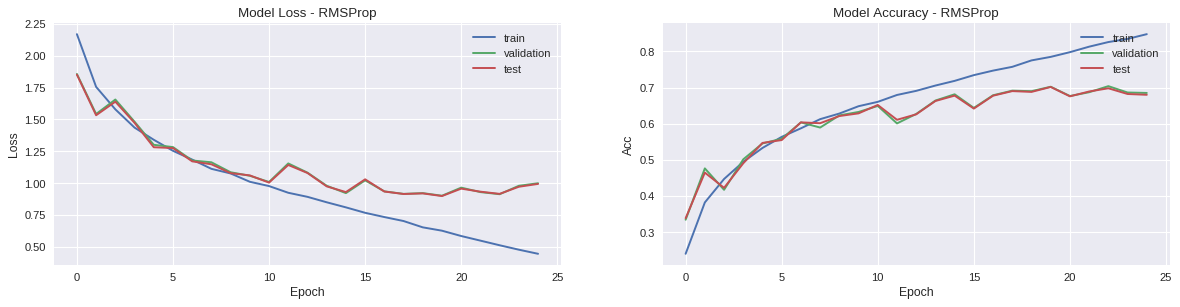

In [11]:
#definimos funciones que ayudaran a modularizar y evitar redundancia de código

def get_metrics_lists(history,history_test):
  loss_train,loss_val,loss_test,acc_train,acc_val,acc_test = list(),list(),list(),list(),list(),list()
  losses = [[] for i in range(3)]
  accs = [[] for i in range(3)]
  for i in range(len(history)):
    loss_train,loss_val,loss_test,acc_train,acc_val,acc_test = history[i].history['loss'],history[i].history['val_loss'],history_test[i][0], history[i].history['acc'],history[i].history['val_acc'],history_test[i][1]
    losses[0].append(loss_train)
    losses[1].append(loss_val)
    losses[2].append(loss_test)
    accs[0].append(acc_train)
    accs[1].append(acc_val)
    accs[2].append(acc_test)
  return losses,accs

def triple_plot(losses, accs,title):
  plt.figure(num=None, figsize=(18, 4), dpi=80, facecolor='w', edgecolor='k')
  plt.subplot(1,2,1)
  plt.plot(losses[0])
  plt.plot(losses[1])
  plt.plot(losses[2])
  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation','test'], loc='upper right')
  plt.subplot(1,2,2)
  plt.plot(accs[0])
  plt.plot(accs[1])
  plt.plot(accs[2])
  plt.title(title.replace("Loss", "Accuracy"))
  plt.xlabel('Epoch')
  plt.ylabel('Acc')
  plt.legend(['train', 'validation','test'], loc='upper right')
  
  plt.show()
  
losses = list()
losses,accs = get_metrics_lists(history_1_e,history_1_e_test)
 
triple_plot(losses,accs,'Model Loss - RMSProp')

Un claro caso de Overfitting en el modelo al usar RMSProp,  sin embargo el valor al  que se empezó a llegar en la valdación y test para el *loss* es menor que haciendo una reducción manual del *learning rate*. Es por lo cual que repetiremos pero probando con una reducción de este problema usando Dropout, así la red no tenderá a crear conexiones demasiado complejas, al obligar a que use otros pesos. Se añadiran 2 Dropout, uno después de la última capa de pooling y otro después de la capa escondida densa.

Epoch 1/25
[TEST]: loss=2.065009334182739, acc= 0.2426
Epoch 2/25
[TEST]: loss=1.5799802841186523, acc= 0.4316
Epoch 3/25
[TEST]: loss=1.570868963241577, acc= 0.4606
Epoch 4/25
[TEST]: loss=1.3948887342453002, acc= 0.5061
Epoch 5/25
[TEST]: loss=1.2468472801208497, acc= 0.5621
Epoch 6/25
[TEST]: loss=1.2017826238632203, acc= 0.574
Epoch 7/25
[TEST]: loss=1.187057710456848, acc= 0.5877
Epoch 8/25
[TEST]: loss=1.1528608545303345, acc= 0.6088
Epoch 9/25
[TEST]: loss=1.1095284996032715, acc= 0.6171
Epoch 10/25
[TEST]: loss=1.1342555080413819, acc= 0.6036
Epoch 11/25
[TEST]: loss=1.075227738380432, acc= 0.6312
Epoch 12/25
[TEST]: loss=1.027505763912201, acc= 0.6475
Epoch 13/25
[TEST]: loss=0.9714725751876832, acc= 0.667
Epoch 14/25
[TEST]: loss=0.9452860289573669, acc= 0.673
Epoch 15/25
[TEST]: loss=0.943823269367218, acc= 0.6716
Epoch 16/25
[TEST]: loss=0.9841116494178772, acc= 0.6635
Epoch 17/25
[TEST]: loss=0.9061716472625733, acc= 0.687
Epoch 18/25
[TEST]: loss=1.0134301454544068, acc= 

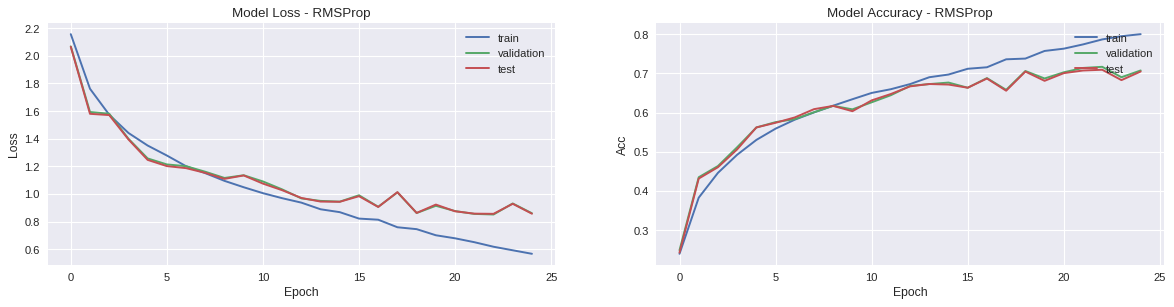

In [0]:
model_1_e_drop = Sequential()
model_1_e_drop.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_e_drop.add(Activation('relu'))
model_1_e_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e_drop.add(Conv2D(64, (3, 3), padding='same'))
model_1_e_drop.add(Activation('relu'))
model_1_e_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_1_e_drop.add(Dropout(0.25))
model_1_e_drop.add(Flatten())
model_1_e_drop.add(Dense(512))
model_1_e_drop.add(Activation('relu'))
model_1_e_drop.add(Dropout(0.25))
model_1_e_drop.add(Dense(10))
model_1_e_drop.add(Activation('softmax'))

opt = rmsprop(lr=0.001, decay=1e-6)
batch_size = 1000
epochs = 25
model_1_e_drop.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'] )
history_1_e_drop, history_1_e_drop_test= get_metrics(model_1_e_drop, data, epochs, batch_size,verbos=0)
losses, accs = get_metrics_lists(history_1_e_drop,history_1_e_drop_test)
triple_plot(losses,accs,'Model Loss - RMSProp')


Como se puede ver se empezó a reducir el Overfitting añadiendo 2 capas de Droput, sin embargo todavía hay cambios que se pueden hacer en el modelo de manera general con el fin de evitar este fenómeno y también mejorar los indices que se obtienen. 

Para los siguientes enunciados usaremos la red con el optimizador SGD junto al *step decay* o *Learning rate scheduler*, dado que a pesar de los mejores resultados con *Dropout* para RMSProp, para poder comparar adecuadamente los métodos y gracias a que los resultados son menos variables y no tienden al *overfitting* será más adecuado usar la red del inciso d).

-----
### 1.f) Variación tamaño filtros de convolución

Se modifica el tamaño de los filtros de convolución, es decir el tamaño de los *kernel*, posteriormente se debe analizar su error antes estos cambios. Lo anterior se realizará para una red *shallow*/poco profunda y una *deep*/profunda. Los tamaños de *kernel* que se probarán serán de la siguiente dimensión (2,2), (3,3) y (4,4). Finalmente se compara los errores para comentar.

#### 1.f.1) Shallow network

Procedemos a entrenar una red *shallow*, dado que serán menos parámetros evitaremos usar dropout para ver el comportamiento. 

In [0]:
models_1_f_shallow = list()
histories_1_f_shallow = list()
histories_1_f_shallow_test = list()
for i in range(3):

    """Shallow network"""
    nc = i+2 #convolutional filter size
    models_1_f_shallow.append(Sequential())
    models_1_f_shallow[i].add(Conv2D(64, (nc,nc), padding='same', input_shape=x_train.shape[1:]))
    models_1_f_shallow[i].add(Activation('relu'))
    models_1_f_shallow[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_shallow[i].add(Flatten())
    models_1_f_shallow[i].add(Dense(512))
    models_1_f_shallow[i].add(Activation('relu'))
    models_1_f_shallow[i].add(Dense(10))
    models_1_f_shallow[i].add(Activation('softmax'))

    #opt = rmsprop(lr=0.001, decay=1e-6)
    opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
    batch_size = 1000
    epochs = 20
    models_1_f_shallow[i].compile(loss="categorical_crossentropy" , optimizer=opt,metrics=['accuracy'] )

    history_1_f_shallow, history_1_f_shallow_test = get_metrics(models_1_f_shallow[i], data, epochs, batch_size,lrate=lrate,verbos=0)
    histories_1_f_shallow.append(history_1_f_shallow)
    histories_1_f_shallow_test.append(history_1_f_shallow_test)

Epoch 1/20
[TEST]: loss=2.2538342235565185, acc= 0.1857
Epoch 2/20
[TEST]: loss=2.2040370655059816, acc= 0.2521
Epoch 3/20
[TEST]: loss=2.1510273849487302, acc= 0.2671
Epoch 4/20
[TEST]: loss=2.099935320663452, acc= 0.2993
Epoch 5/20
[TEST]: loss=2.0540681718826295, acc= 0.3002
Epoch 6/20
[TEST]: loss=2.013768721008301, acc= 0.3108
Epoch 7/20
[TEST]: loss=1.9793647331237794, acc= 0.3227
Epoch 8/20
[TEST]: loss=1.9499265941619872, acc= 0.3337
Epoch 9/20
[TEST]: loss=1.9258337656021118, acc= 0.3426
Epoch 10/20
[TEST]: loss=1.9063713474273682, acc= 0.3429
Epoch 11/20
[TEST]: loss=1.8886244514465331, acc= 0.3532
Epoch 12/20
[TEST]: loss=1.8737620401382447, acc= 0.3579
Epoch 13/20
[TEST]: loss=1.8597946273803712, acc= 0.3578
Epoch 14/20
[TEST]: loss=1.8476222911834717, acc= 0.3652
Epoch 15/20
[TEST]: loss=1.8366503395080567, acc= 0.3696
Epoch 16/20
[TEST]: loss=1.8243448049545288, acc= 0.3734
Epoch 17/20
[TEST]: loss=1.8141281480789184, acc= 0.3781
Epoch 18/20
[TEST]: loss=1.803158108901977

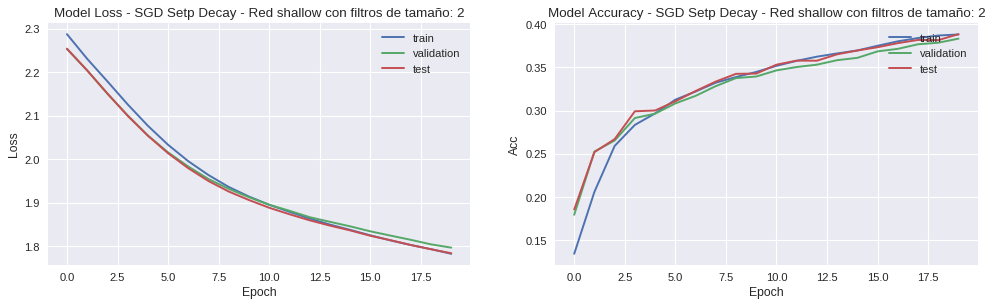

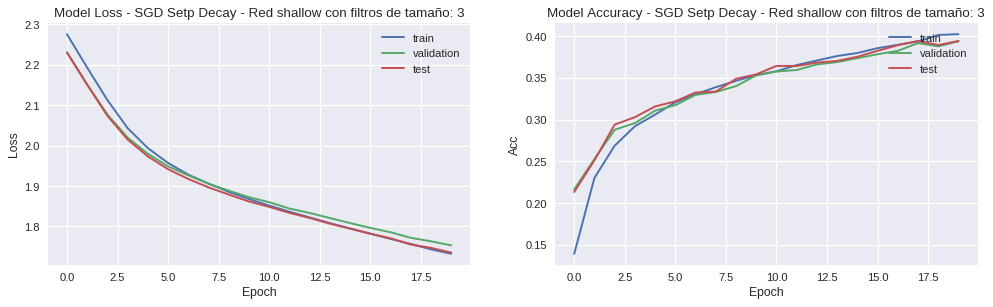

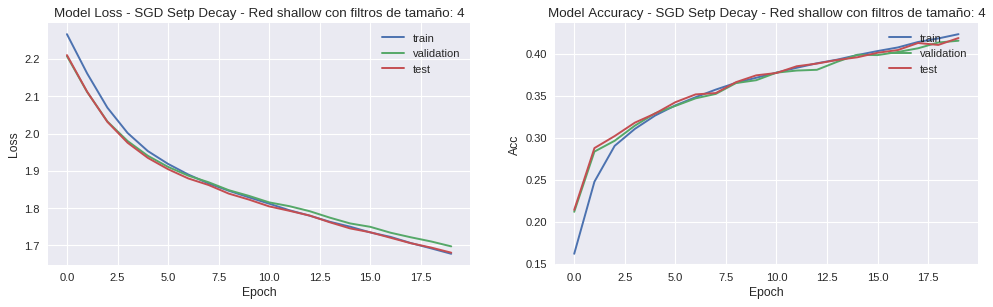

In [0]:
#ploteo de 3 modelos shallow con distintos filtros convolucionales
losses_list = list()
accs_list = list()
for i in range(3):
  losses, accs = get_metrics_lists(histories_1_f_shallow[i],histories_1_f_shallow_test[i])
  losses_list.append(losses)
  accs_list.append(accs)
  triple_plot(losses, accs, "Model Loss - SGD Setp Decay - Red shallow con filtros de tamaño: " +  str(i+2))

En general los filtros entregan valores similares, es clave notar que a pesar de usar una capa convolucional menos se llegan a resultados mejores que en la red del inciso d).  Por último se puede ver que los mayores filtros entregaron un mejor resultado, pudiendose deber a que generaban "más visión" de las imágenes. 

#### 1.f.2) Dense network

Para este caso usaremos una red densa con la arquitectura: $C \times P \times C \times P \times C \times P   \times F \times F$ y de esta manera entrenaremos para posteriormente comparar con la red *shallow* previamente usada en la clasificación.

In [0]:
models_1_f_dense = list()
histories_1_f_dense = list()
histories_1_f_dense_test = list()
for i in range(3):

    """dense network"""
    nc = i+2 #convolutional filter size
    models_1_f_dense.append(Sequential())
    models_1_f_dense[i].add(Conv2D(64, (nc,nc), padding='same', input_shape=x_train.shape[1:]))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_dense[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_dense[i].add(Conv2D(64, (nc,nc), padding='same'))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_dense[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_dense[i].add(Conv2D(64, (nc,nc), padding='same'))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_dense[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_f_dense[i].add(Flatten())
    models_1_f_dense[i].add(Dense(512))
    models_1_f_dense[i].add(Activation('relu'))
    models_1_f_shallow[i].add(Dropout(0.25))
    models_1_f_dense[i].add(Dense(10))
    models_1_f_dense[i].add(Activation('softmax'))
    
    opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
    #opt = rmsprop(lr=0.001, decay=1e-6)
    batch_size = 1000
    epochs = 20
    models_1_f_dense[i].compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'] )

    history_1_f_dense, history_1_f_dense_test = get_metrics(models_1_f_dense[i], data, epochs, batch_size, lrate=lrate)
    histories_1_f_dense.append(history_1_f_dense)
    histories_1_f_dense_test.append(history_1_f_dense_test)

Epoch 1/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 142us/step
[TEST]: loss=2.2974140411376953, acc= 0.1017
Epoch 2/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 143us/step
[TEST]: loss=2.2923014877319337, acc= 0.1238
Epoch 3/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 141us/step
[TEST]: loss=2.2874103286743166, acc= 0.158
Epoch 4/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 141us/step
[TEST]: loss=2.2821015808105467, acc= 0.1755
Epoch 5/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 144us/step
[TEST]: loss=2.2761239635467527, acc= 0.1801
Epoch 6/20
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] 

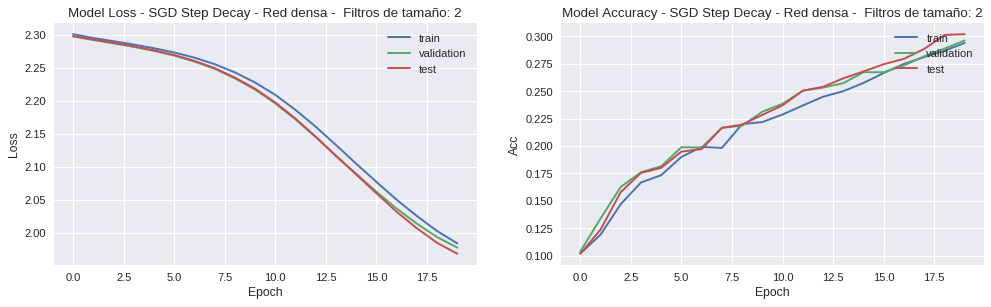

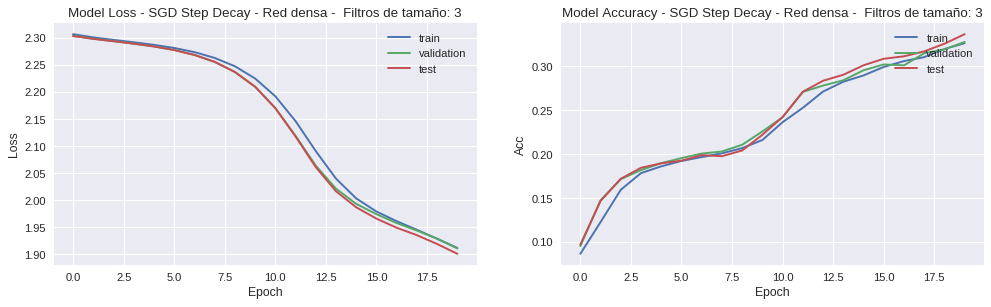

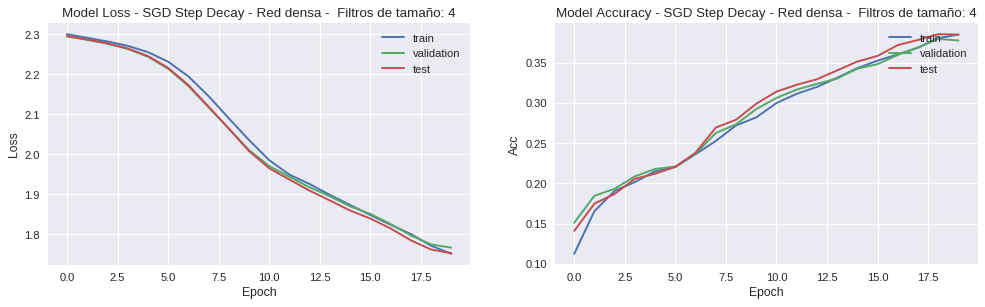

In [0]:
#ploteo de 3 modelos dense con distintos filtros convolucionales
losses_list_1_f_dense = list()
accs_list_1_f_dense = list()
for i in range(3):
  losses, accs = get_metrics_lists(histories_1_f_dense[i],histories_1_f_dense_test[i])
  losses_list_1_f_dense.append(losses)
  accs_list_1_f_dense.append(accs)
  triple_plot(losses, accs, "Model Loss - SGD Step Decay - Red profunda -  Filtros de tamaño: " +  str(i+2))
 



La red *shallow* obtuvo resultados ligeramente mejores, siendo de manera general bajos en el objetvo final de la red. Por otro lado se pudo notar que se mejoraron levemento los indices de error y *accuracy* al aumentar el tamaño de los filtros utilizados también para el caso de la red densa, algo que nos servirá para los experimentos posteriores.

----
### 1.g) Variación filtros de convolución

Ahora procederemos a probar el desempeño de una red neuronal con Pooling y otra con menor cantidad, esto para poder analizar los efectos de evitar una reducción dimensional rápidamente en la red. Por otro lado, usaremos la proporción 1:2 entre número de filtros antes y después de la primera capa de pooling. De 64 filtros para doblar a 128 entre la(s) primera(s) capa(s) y la(s) segunda(s). Notar que además probaremos variar el tamaño de los filtros también.

#### 1.g.1) Arquitectura con Pooling después de cada capa convolucional

Se usará la siguiente arquitectura $C \times P \times C \times P \times F \times F$, la cual es igual a la que hemos estado usando hasta ahora.

In [0]:
models_1_g = list()
histories_1_g = list()
histories_1_g_test = list()
for i in range(3):
    """dense network"""
    nc = 3 #convolutional filter size
    aux = nc
    models_1_g.append(Sequential())
    if i == 2:
      aux=5
    models_1_g[i].add(Conv2D(64, (aux,aux), padding='same', input_shape=x_train.shape[1:]))
    aux=nc
    models_1_g[i].add(Activation('relu'))
    models_1_g[i].add(MaxPooling2D(pool_size=(2, 2)))
    if i == 1:
        aux=5
    models_1_g[i].add(Conv2D(128, (aux,aux), padding='same'))
    models_1_g[i].add(Activation('relu'))
    models_1_g[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_g[i].add(Flatten())
    models_1_g[i].add(Dense(512))
    models_1_g[i].add(Activation('relu'))
    models_1_g[i].add(Dense(10))
    models_1_g[i].add(Activation('softmax'))

    opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
    epochs = 25
    models_1_g[i].compile(loss="categorical_crossentropy" , optimizer=opt ,metrics=['accuracy'])
    history_1_g, history_1_g_test = get_metrics(models_1_g[i], data, epochs, batch_size,lrate=lrate)
    histories_1_g.append(history_1_g)
    histories_1_g_test.append(history_1_g_test)


Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 157us/step
[TEST]: loss=2.271052300262451, acc= 0.1567
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 154us/step
[TEST]: loss=2.2386913867950438, acc= 0.2116
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 155us/step
[TEST]: loss=2.197075975036621, acc= 0.2492
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 157us/step
[TEST]: loss=2.1461703800201417, acc= 0.2728
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 156us/step
[TEST]: loss=2.095042204284668, acc= 0.2829
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 

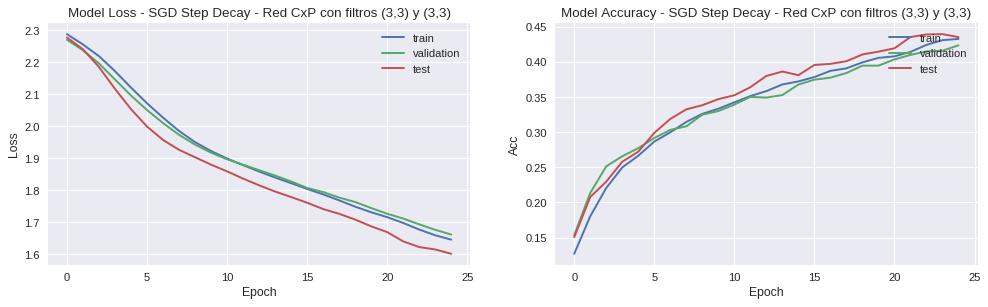

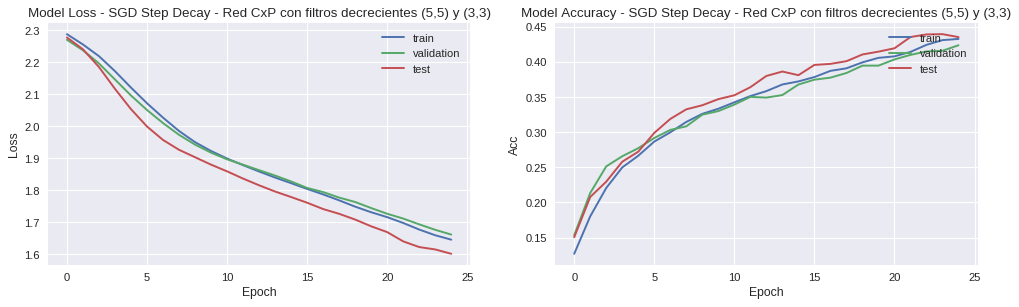

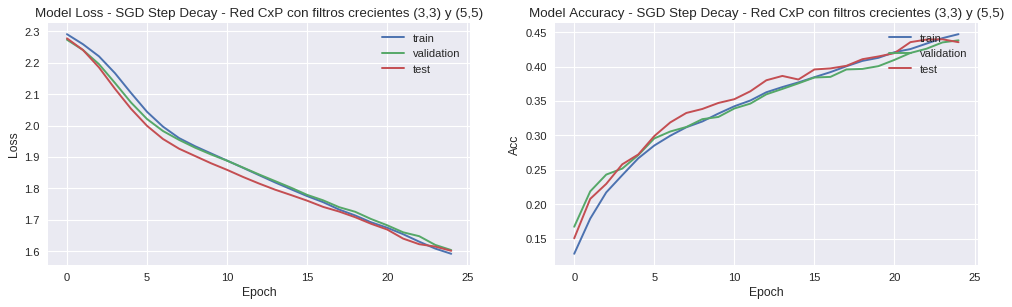

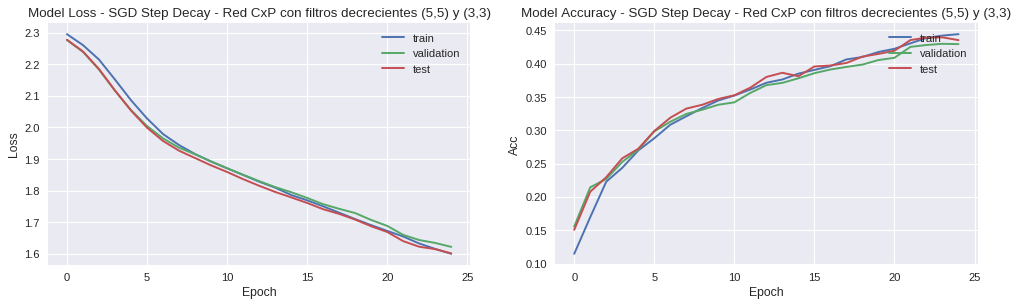

In [0]:
losses_list_1_g = list()
accs_list_1_g = list()
for i in range(3):
  losses, accs = get_metrics_lists(histories_1_g[i],history_1_g_test)
  losses_list_1_g.append(losses)
  accs_list_1_g.append(accs)
  if i == 0:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - Red CxP con filtros (3,3) y (3,3)')
  if i == 1:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - Red CxP con filtros crecientes (3,3) y (5,5)')
  else:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - Red CxP con filtros decrecientes (5,5) y (3,3)')

De los gráficos podemos notar los casos en los cuales el *loss* de test es menor al de validación y entrenamiento. Notamos que se obtienen resultados levemente mejores para los indices de *Test* en el caso de variar el tamaño de los filtros de manera creciente (3x3) => (5x5).

#### 1.g.2) Arquitectura con Pooling después de 2 capas convolucionales   

Se usará la siguiente arquitectura:  $C \times C \times P \times C \times C \times P \times F \times F$. Con 64 filtros para las primeras 2 capas Conv. y 128 para las 2 siguientes. Notamos que estas iteraciones serán mucho más demorosas debido al aumento de parámetros.


In [0]:
models_1_g_nopool = list()
histories_1_g_nopool = list()
histories_1_g_nopool_test = list()
for i in range(3):
    """dense network"""
    nc = 3 #convolutional filter size
    aux = nc
    models_1_g_nopool.append(Sequential())
    if i == 2:
      aux = 5
    models_1_g_nopool[i].add(Conv2D(64, (aux,aux), padding='same', input_shape=x_train.shape[1:]))
    models_1_g_nopool[i].add(Activation('relu'))
    models_1_g_nopool[i].add(Conv2D(64, (aux,aux), padding='same', input_shape=x_train.shape[1:]))
    models_1_g_nopool[i].add(Activation('relu'))
    models_1_g_nopool[i].add(MaxPooling2D(pool_size=(2, 2)))
    aux = nc
    if i == 1:
      aux = 5
    models_1_g_nopool[i].add(Conv2D(128, (aux,aux), padding='same'))
    models_1_g_nopool[i].add(Activation('relu'))
    models_1_g_nopool[i].add(Conv2D(128, (aux,aux), padding='same'))
    models_1_g_nopool[i].add(Activation('relu'))
    models_1_g_nopool[i].add(MaxPooling2D(pool_size=(2, 2)))
    models_1_g_nopool[i].add(Flatten())
    models_1_g_nopool[i].add(Dense(512))
    models_1_g_nopool[i].add(Activation('relu'))
    models_1_g_nopool[i].add(Dense(10))
    models_1_g_nopool[i].add(Activation('softmax'))

    opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
    lrate = LearningRateScheduler(step_decay)
    epochs = 25
    models_1_g_nopool[i].compile(loss="categorical_crossentropy" , optimizer=opt ,metrics=['accuracy'])
    history_1_g_nopool, history_1_g_nopool_test = get_metrics(models_1_g_nopool[i], data, epochs, batch_size, lrate=lrate)
    histories_1_g_nopool.append(history_1_g_nopool)
    histories_1_g_nopool_test.append(history_1_g_nopool_test)

Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 228us/step
[TEST]: loss=2.2955352352142335, acc= 0.1486
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 232us/step
[TEST]: loss=2.2861987464904785, acc= 0.132
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 234us/step
[TEST]: loss=2.273094067764282, acc= 0.1388
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 231us/step
[TEST]: loss=2.250727025985718, acc= 0.1819
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2s 230us/step
[TEST]: loss=2.207705825805664, acc= 0.2075
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 2

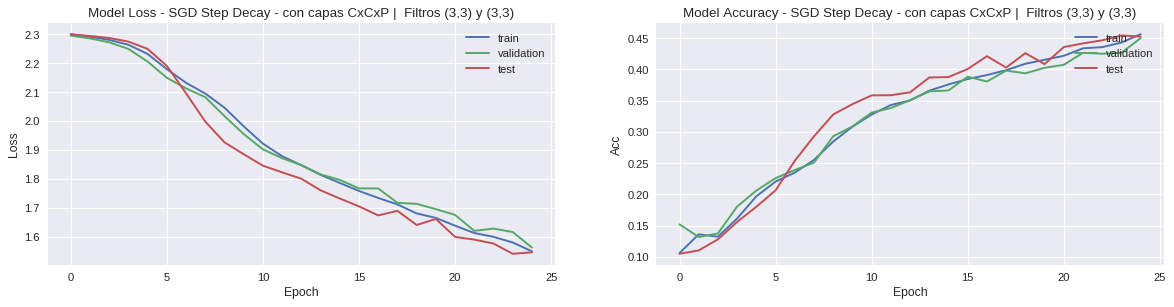

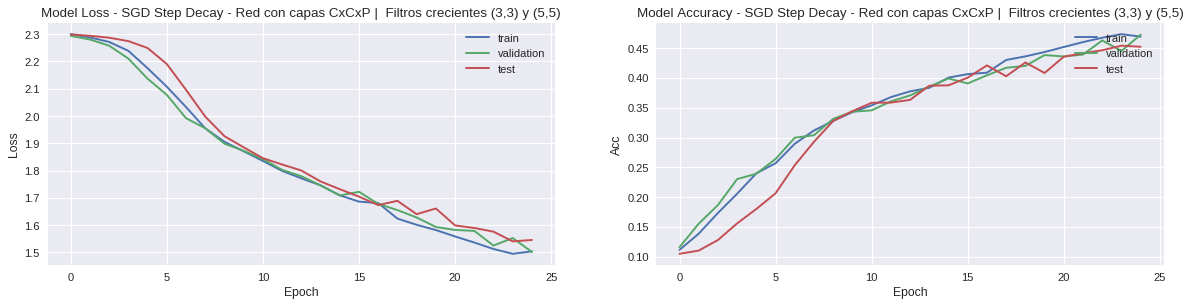

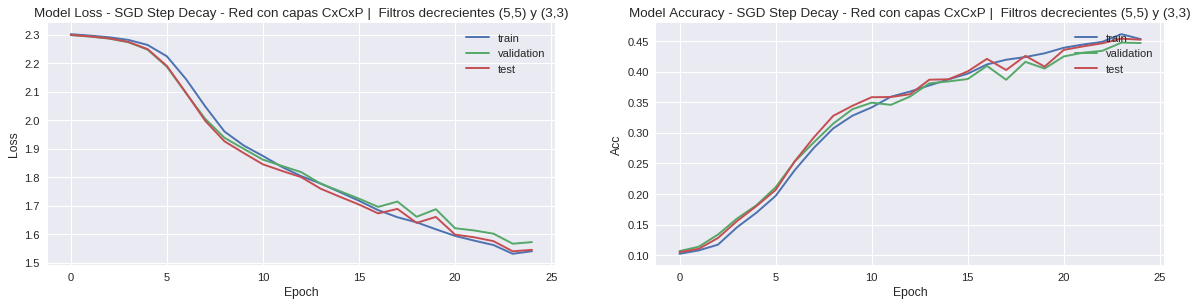

In [0]:
losses_list_1_g_nopool = list()
accs_list_1_g_nopool = list()
for i in range(3):
  losses, accs = get_metrics_lists(histories_1_g_nopool[i],history_1_g_nopool_test)
  losses_list_1_g_nopool.append(losses)
  accs_list_1_g_nopool.append(accs)
  if i == 0:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - con capas CxCxP |  Filtros (3,3) y (3,3)')
  if i == 1:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - Red con capas CxCxP |  Filtros crecientes (3,3) y (5,5)')
  if i == 2:
      triple_plot(losses, accs,'Model Loss - SGD Step Decay - Red con capas CxCxP |  Filtros decrecientes (5,5) y (3,3)')

Finalmente podemos apreciar que los resultados en general son similares al caso anterior con la arquitectura anterior, e inclusive la tendencia de que al aumentar el tamaño de los filtros se obtienen mejores resultados se mantiene. Se puede concluir que no existe la necesidad de realizar 2 capas convolucionales seguidas dado que el pooling de igual manera tomará un promedio o el máximo (máximo en este caso) y realizara una reducción dimensional. Se se deseara mantener toda la información, entonces se debería quitar la capa de pooling. También que el usar filtros convolucionales menores al principio permite fijarse en los detalles por separados que son útiles para clasificar las clases, sin embargo como en capas posteriores nos interesa más la relación de estos atributos el usar  un *kernel* más grande nos trae mayor ventaja al acaparar más información.

------
### 1.h)  Convolución con stride

Ahora se verificará si efectivamente existe una reducción dimensional al usar *stride* en las capas convolucionales, y de tal manera se reemplace la capa de pooling. El stride define entonces la manera en la que se ejecuta la convolución con el filtro, saltandose más resultados al usar un *stride* mayor, (se mueve a más grandes espacios).

In [0]:
model_1_h = Sequential()
model_1_h.add(Conv2D(128, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model_1_h.add(Activation('relu'))
model_1_h.add(Conv2D(128, (3, 3), padding='same'))
model_1_h.add(Activation('relu'))
model_1_h.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
model_1_h.add(Activation('relu'))
model_1_h.add(Flatten())
model_1_h.add(Dense(512))
model_1_h.add(Activation('relu'))
model_1_h.add(Dense(10))
model_1_h.add(Activation('softmax'))
model_1_h.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 32, 32, 128)       3584      
_________________________________________________________________
activation_252 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 32, 32, 128)       147584    
_________________________________________________________________
activation_253 (Activation)  (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 16, 16, 64)        73792     
_________________________________________________________________
activation_254 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_65 (Flatten)         (None, 16384)             0         
__________

Efectivamente la dimensión de output se reduce a la mitad al igual que hacer un *Pooling* de 2x2, esto debido a la manera en la cual se realiza la convolución con *stride=2*, el cual no hace un "traslape" entre cada multiplicación. 

Se procede a entrenar la red y ver su error como también el *accuracy* al que llega con este nuevo tipo de reducción dimensional.

Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 321us/step
[TEST]: loss=2.286032634735107, acc= 0.1161
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 306us/step
[TEST]: loss=2.2570985218048096, acc= 0.1311
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 306us/step
[TEST]: loss=2.1925386039733885, acc= 0.2149
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 308us/step
[TEST]: loss=2.079236248397827, acc= 0.2651
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 305us/step
[TEST]: loss=1.9780175930023194, acc= 0.3075
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] -

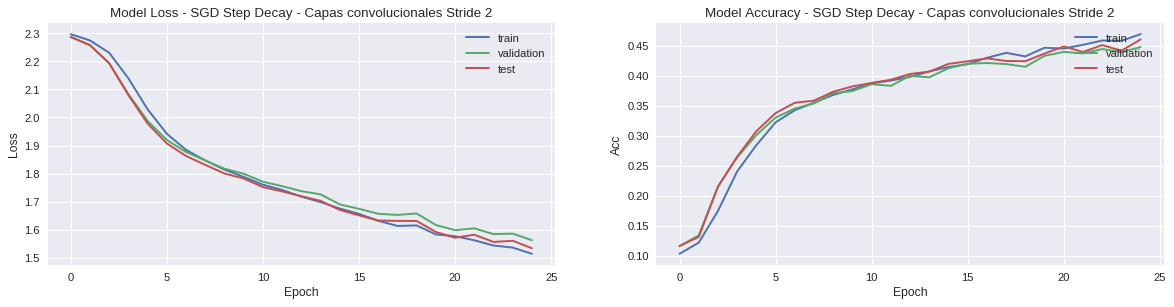

In [0]:
opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
batch_size = 1000
epochs = 25
model_1_h.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'])
history_1_h, history_1_h_test = get_metrics(model_1_h, data, epochs, batch_size,lrate=lrate,verbos=1)
losses_1_h, accs_1_h = get_metrics_lists(history_1_h,history_1_h_test) 
triple_plot(losses_1_h, accs_1_h,'Model Loss - SGD Step Decay - Capas convolucionales Stride 2')


El resultado obtenido es de los mejores hasta ahora, sin embargo también hay que notar el mayor tiempo que tomo entrenar esta red en relación a la que posee la capa de pooling. Claramente por la cantidad de parámetros que de igual manera nos quedaremos, dado que no se reduce totalmente la dimensión de la capa convolucional anterior. De todas maneras puede ser una alternativa interesante usar esta capa convolucional que imita el pooling, ya que se llegó a un buen resultado.

-----
### 1.i) Aumento del dataset

Ahora probaremos creando más datos a partir de los existentes agregando ruido a las imágenes. Esto con el fin de crear una red más robusta en la clasificación, ahora se verá el resultado de entrenar con ellos. Para lo cual usaremos una red con la arquitectura $C  \times P \times C  \times P \times F \times F$. 

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    rotation_range=0, # randomly rotate images (degrees, 0 to 180)
    width_shift_range=0.1, # randomly shift images horizontally (fraction of width)
    height_shift_range=0.1, # randomly shift images vertically (fraction of height)
    horizontal_flip=True, # randomly flip images
    vertical_flip=False) # randomly flip images
datagen.fit(x_train)

In [0]:
model_1_i = Sequential()
model_1_i.add(Conv2D(64, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model_1_i.add(Activation('relu'))
model_1_i.add(MaxPooling2D(pool_size=(2, 2)))
model_1_i.add(Conv2D(64, (3, 3), padding='same'))
model_1_i.add(Activation('relu'))
model_1_i.add(MaxPooling2D(pool_size=(2, 2)))
model_1_i.add(Flatten())
model_1_i.add(Dense(512))
model_1_i.add(Activation('relu'))
model_1_i.add(Dense(10))
model_1_i.add(Activation('softmax'))
model_1_i.summary()

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
batch_size = 1000
epochs = 25
model_1_i.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'])

history_1_i = model_1_i.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch=x_train.shape[0]//
                                      batch_size, epochs=epochs,validation_data=(x_test, y_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_261 (Activation)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
activation_262 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_67 (Flatten)         (None, 4096)              0         
__________

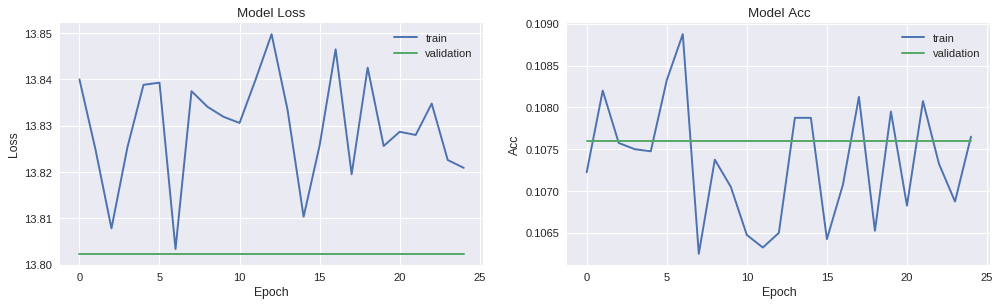

In [0]:
plt.figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1)
plt.plot(history_1_i.history['loss'])
plt.plot(history_1_i.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper right')
plt.subplot(1,2,2)
plt.plot(history_1_i.history['acc'])
plt.plot(history_1_i.history['val_acc'])
plt.title('Model Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Los resultados a los que se llega son malos, puede deberse tanto a que la arquitectura no es la adecuada. O que el número de variaciones son muchas como para que la red comience a ajustarse. Por otro lado, la perdida en validación se mantiene constante,  dado que existe una gran varianza entre estas imagenes y las que se están usando para el entrenamiento.

-----
### 1.j) Opencv

Ahora usaremos la útil librería Opencv para proceder a calcular los descriptores manuales *sift* (Scale Invariant Feature Transform) de las imágenes que hemos estado usando.  El algoritmo se basa primero en realizar una diferencia Gaussiana en 2 imagenes, calcular los óptimos locales que podrían ser posibles *keypoints*,  luego se eliminan los bordes. Posteriormente, con los *strong interest points* se asigna una orientación basado en los vecinos del pixel, tomando en cuenta los más notorios para poder tener puntos resistentes a distintas orientaciones.

In [0]:
!pip install opencv-python==3.1.0.4 opencv-contrib-python==3.4.2.16

    100% |████████████████████████████████| 6.2MB 1.6MB/s 
    100% |████████████████████████████████| 30.6MB 1.5MB/s 
  Found existing installation: opencv-python 3.4.3.18
    Uninstalling opencv-python-3.4.3.18:
      Successfully uninstalled opencv-python-3.4.3.18


In [0]:
import cv2
def pre_process(img):
    if np.max(img) <= 1:
        img*=255
    img = img.astype("uint8")
    img_gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img_gray
def calculate_sift(cifar):
    sift_cifar = []
    kp_cifar = []
    for image in cifar:
      img_gray = pre_process(image)
      sift = cv2.xfeatures2d.SIFT_create()
      kp, desc = sift.detectAndCompute(img_gray, None)
      if type(desc) == type(None):
        desc = np.zeros((1,128))
      compress_desc = np.mean(desc,axis=0) #compress all keypoints
      kp_cifar.append(kp)
      sift_cifar.append(compress_desc)
    return np.asarray(sift_cifar),np.asarray(kp_cifar)
cifar_sift,kp_cifar = calculate_sift(x_train)
cifar_sift_val,kp_cifar_val = calculate_sift(x_val)
cifar_sift_test,kp_cifar_test = calculate_sift(x_test)

Ya con los descriptores y *keypoints* calculados, procedemos a mostrar su ubicación para la primera imagen del dataset.  

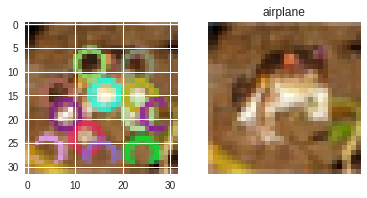

In [0]:
def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

# generate SIFT keypoints and descriptors
kp = kp_cifar[0]
sift = cifar_sift[0]

plt.subplot(1,2,1)
show_sift_features(x_train[0], x_train[0], kp)
plt.subplot(1,2,2)
plt.title(label_names[int(y_train[0][0])])
plt.axis('off')
_=plt.imshow(x_train[0])


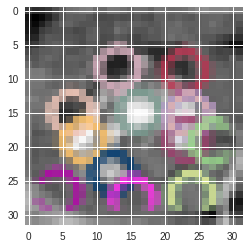

In [0]:
sample_image = x_train[0]
gray_sample_image = pre_process(sample_image)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray_sample_image, None)
"""draw and plot"""
img=cv2.drawKeypoints(gray_sample_image,kp,sample_image.copy())
plt.imshow(img)
plt.show()

Ahora que entendemos el propósito de los descriptores *sift* y los *keypoints* respectivos, creamoos una red con una capa densa ocupando solo los valores obtenidos con este algoritmo: 

### 1.j.1) Red Densa #1

Como siempre partimos normalizando los datos con los cuales entrenaremos:

In [0]:
cifar_sift.shape[1:]
#normalizamos
cifar_sift = cifar_sift.copy()/cifar_sift.max()
cifar_sift_val = cifar_sift_val.copy()/cifar_sift_val.max()
cifar_sift_test = cifar_sift_test.copy()/cifar_sift_test.max()

data_sift = [cifar_sift, y_train, cifar_sift_val, y_val, cifar_sift_test, y_test]


Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 0s 48us/step
[TEST]: loss=2.302780170440674, acc= 0.1099
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 0s 49us/step
[TEST]: loss=2.3007087188720705, acc= 0.1127
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 52us/step
[TEST]: loss=2.29891540145874, acc= 0.1144
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 53us/step
[TEST]: loss=2.2972840267181396, acc= 0.1146
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 52us/step
[TEST]: loss=2.2957739810943605, acc= 0.1168
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 52

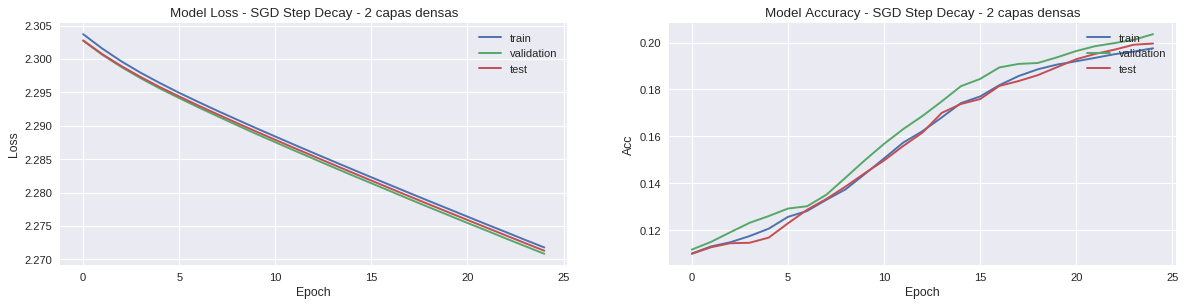

In [0]:
model_1_j = Sequential()
model_1_j.add(Dense(512,input_shape=cifar_sift.shape[1:]))
model_1_j.add(Activation('relu'))
model_1_j.add(Dense(10))
model_1_j.add(Activation('softmax'))

opt = SGD(lr=0.0, momentum=0.9, decay=0.0)
batch_size = 1000
epochs = 25
model_1_j.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'])
history_1_j, history_1_j_test = get_metrics(model_1_j, data_sift, epochs, batch_size,lrate=lrate,verbos=1)
losses_1_j, accs_1_j = get_metrics_lists(history_1_j,history_1_j_test) 
triple_plot(losses_1_j, accs_1_j,'Model Loss - SGD Step Decay - 1 capa densa')

Se puede notar que los indices para la validación y prueba son mejores que para el entrenamiento. Los resultados no son buenos, el *accuracy* al que se llega es de alrededor del 20%, pero la clara ventaja esta en el entrenamiento debido a los pocos parámetros que necesitamos y el evitar usar una capa convolucional para entrenar.

### 1.j.1) Red Densa con optimizador RMSProp

Para motivos experimentales probamos con RMSProp, dado que este tuvo buenos resultados en el inciso e). Así contrastaremos la utilidad de estos descriptores bajo la prueba con optimizadores distintos.

Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 0s 49us/step
[TEST]: loss=2.131779801940918, acc= 0.2352
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 51us/step
[TEST]: loss=2.0923038646698, acc= 0.2307
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 53us/step
[TEST]: loss=2.069464772415161, acc= 0.2525
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 54us/step
[TEST]: loss=2.0432182815551756, acc= 0.2656
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 54us/step
[TEST]: loss=2.026391752243042, acc= 0.2792
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 1s 53us/

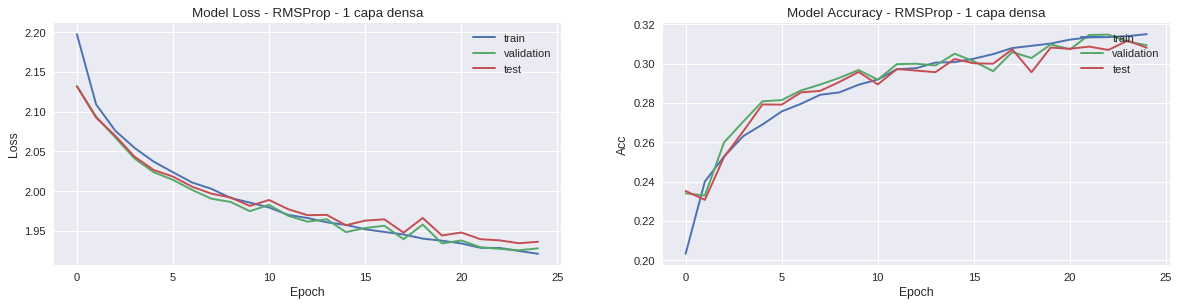

In [0]:
model_1_j_2 = Sequential()
model_1_j_2.add(Dense(512,input_shape=cifar_sift.shape[1:]))
model_1_j_2.add(Activation('relu'))
model_1_j_2.add(Dense(10))
model_1_j_2.add(Activation('softmax'))


opt = rmsprop(lr=0.001, decay=1e-6)
batch_size = 1000
epochs = 25
model_1_j_2.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'])
history_1_j_2, history_1_j_2_test = get_metrics(model_1_j_2, data_sift, epochs, batch_size,verbos=1)
losses_1_j_2, accs_1_j_2 = get_metrics_lists(history_1_j_2,history_1_j_2_test) 
triple_plot(losses_1_j_2, accs_1_j_2,'Model Loss - RMSProp - 1 capa densa')

El resultado es favorable pero de igual manera se llegan a valores malos respecto al *loss* y *accuracy* en comparación a las redes anteriores. Pero el tiempo de computo fue extremadamente menor también. Los descriptores son una herramienta muy util para poder identificar puntos claves en las imágenes, podría ser interesante como combinar o utilizarlos de mejor manera con una red convolucional "entera".

----
### Intermedio

Previo a las siguientes 2 últimas secciones, se procederá a entrenar una nueva red con RMSProp. Esto debido a que ya tenemos como base los resultados a los que se llego con el otro optimizador variando tamaño de filtros, número de capas convolucionales, etc. Por lo cual aplicaremos la arquitectura que obtuvo mejores resultados a esta nueva red, introduciendo capas propias débido a la naturaleza de este adaptador del *learning rate*.

Los mejores resultados fueron obtenidos con la arquitectura  $C \times C \times P \times C \times C \times P \times F \times F$,  aumentando el tamaño del *kernel*  de manera creciente. Se debe notar la gran cantidad de parámetros que se usarán:

Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 281us/step
[TEST]: loss=2.186272821044922, acc= 0.1757
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 273us/step
[TEST]: loss=1.7468869840621948, acc= 0.3624
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 283us/step
[TEST]: loss=1.6994847946166993, acc= 0.3933
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 283us/step
[TEST]: loss=1.6732314308166505, acc= 0.3869
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 272us/step
[TEST]: loss=1.3974878437042237, acc= 0.5089
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] 

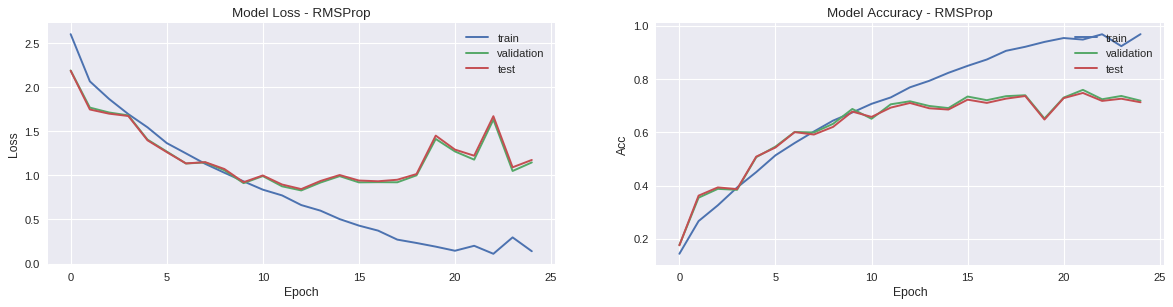

In [0]:
model_1_final = Sequential()
model_1_final.add(Conv2D(64, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_1_final.add(Activation('relu'))
model_1_final.add(Conv2D(64, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_1_final.add(Activation('relu'))
model_1_final.add(MaxPooling2D(pool_size=(2, 2)))
model_1_final.add(Conv2D(128, (5,5), padding='same'))
model_1_final.add(Activation('relu'))
model_1_final.add(Conv2D(128, (5,5), padding='same'))
model_1_final.add(Activation('relu'))
model_1_final.add(MaxPooling2D(pool_size=(2, 2)))
model_1_final.add(Flatten())
model_1_final.add(Dense(512))
model_1_final.add(Activation('relu'))
model_1_final.add(Dense(10))
model_1_final.add(Activation('softmax'))

opt = rmsprop(lr=0.001, decay=1e-6)
batch_size = 1000
epochs = 25
model_1_final.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'])
history_1_final, history_1_final_test = get_metrics(model_1_final, data, epochs, batch_size,verbos=1)
losses_1_final, accs_1_final = get_metrics_lists(history_1_final,history_1_final_test) 
triple_plot(losses_1_final, accs_1_final,'Model Loss - RMSProp')


Se puede ver que a pesar de llegar a los mejores resultados respecto al loss y precisión respecto al set de validación y test, tenemos un grave caso de Overfitting  partir de la época 10 de entrenamiento. Por lo cual probaremos nuevamente agregando *dropout* (claramente no es la mejor opción para CNN pero debido a que se esta en la primera etapa de la tarea se usara) para lograr una mejor **generalización**.

Epoch 1/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 277us/step
[TEST]: loss=2.2470384414672853, acc= 0.2093
Epoch 2/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 270us/step
[TEST]: loss=2.051450704956055, acc= 0.2417
Epoch 3/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 271us/step
[TEST]: loss=1.7621216926574708, acc= 0.3755
Epoch 4/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 273us/step
[TEST]: loss=1.6475428646087646, acc= 0.4071
Epoch 5/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 3s 272us/step
[TEST]: loss=1.3685978393554687, acc= 0.506
Epoch 6/25
Train on 40000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] -

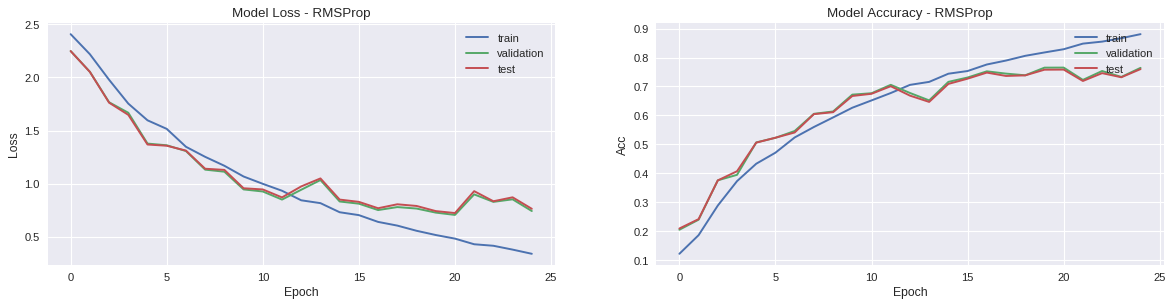

In [12]:
model_1_final_dropout = Sequential()
model_1_final_dropout.add(Conv2D(64, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_1_final_dropout.add(Activation('relu'))
model_1_final_dropout.add(Conv2D(64, (3,3), padding='same', input_shape=x_train.shape[1:]))
model_1_final_dropout.add(Activation('relu'))
model_1_final_dropout.add(MaxPooling2D(pool_size=(2, 2)))
model_1_final_dropout.add(Dropout(0.4))
model_1_final_dropout.add(Conv2D(128, (5,5), padding='same'))
model_1_final_dropout.add(Activation('relu'))
model_1_final_dropout.add(Conv2D(128, (5,5), padding='same'))
model_1_final_dropout.add(Activation('relu'))
model_1_final_dropout.add(MaxPooling2D(pool_size=(2, 2)))
model_1_final_dropout.add(Dropout(0.4))
model_1_final_dropout.add(Flatten())
model_1_final_dropout.add(Dense(512))
model_1_final_dropout.add(Activation('relu'))
model_1_final_dropout.add(Dropout(0.4))
model_1_final_dropout.add(Dense(10))
model_1_final_dropout.add(Activation('softmax'))

opt = rmsprop(lr=0.001, decay=1e-6)
batch_size = 1000
epochs = 25
model_1_final_dropout.compile(loss="categorical_crossentropy" , optimizer=opt, metrics=['accuracy'])
history_1_final_dropout, history_1_final_dropout_test = get_metrics(model_1_final_dropout, data, epochs, batch_size,verbos=1)
losses_1_final_dropout, accs_1_final_dropout = get_metrics_lists(history_1_final_dropout,history_1_final_dropout_test) 
triple_plot(losses_1_final_dropout, accs_1_final_dropout,'Model Loss - RMSProp')

Con esta red se logran los mejores resultados hasta ahora para la tarea de clasificación, tomando en cuenta el *loss* y *accuracy* de valicación y pruebas. Por lo cual se usará la última red para los análisis posteriores.

-----
### 1.k)   Clases problemáticas

Se analizará ahora que clases tiende a confundir la red en la clasificación, se creará una matriz de confusión respecto a los resultados obtenidos. Luego se obtendrán en cuales se suele repetir más los errores para de esta manera, poder entender la causa de las malas clasificaciones. Para esto obtendremos la matriz de confusión, y posteriormente se graficará usando Matplotlib.

In [0]:
def transform_categorical_pred(y_pred):
  
  y_aux = list()
  for i in range(len(y_pred)):
    index = np.argmax(y_pred[i])
    y_aux.append(index)
  return y_aux

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_k = model_1_final_dropout.predict(x_test_norm)

#se transforman desde ser categoricos

y_pred_k_num = transform_categorical_pred(y_pred_k)
y_test_num = transform_categorical_pred(y_test)
#matriz de confusion
cm = confusion_matrix(y_test_num, y_pred_k_num)

array([[797,  14,  35,  16,   9,   9,   6,   8,  45,  61],
       [  5, 879,   0,   4,   0,   5,   2,   0,   9,  96],
       [ 50,   8, 709,  50,  37,  78,  27,  21,   6,  14],
       [ 26,  10,  56, 552,  31, 240,  24,  20,  13,  28],
       [ 24,   8, 102,  72, 624,  72,  26,  55,   8,   9],
       [  8,   4,  33, 101,  16, 783,  10,  22,   8,  15],
       [  5,  10,  54,  60,  13,  69, 750,   4,  11,  24],
       [ 11,   4,  28,  34,  31,  86,   1, 790,   0,  15],
       [ 36,  31,  14,  10,   2,  12,   0,   1, 849,  45],
       [ 10,  37,   4,   9,   0,   9,   3,   2,   8, 918]])

Confusion matrix, without normalization


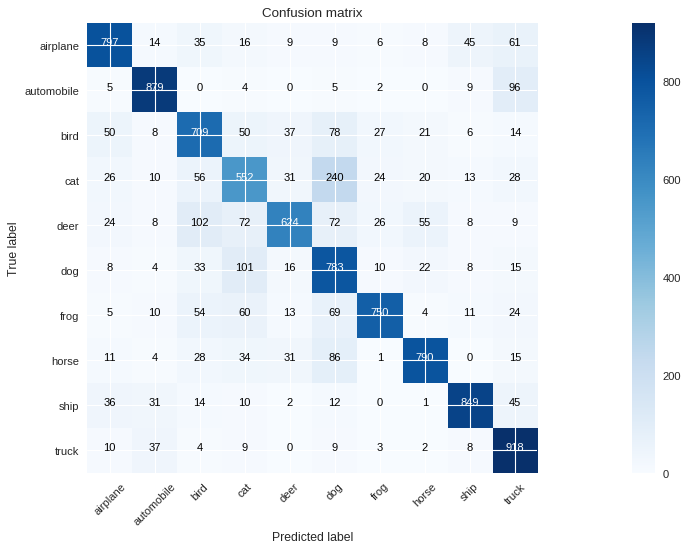

In [0]:
#función de ploteo para la matriz de confusión, donde se pueden agregar los labels
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(num=None, figsize=(24, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
plot_confusion_matrix(cm,label_names)

Analizando la matriz de confusión obtenida con la red final, se pueden rápidamente apreciar los casos de pares en cuales hay más confusión en la clasificación (en orden descendente):


* **Predicción/True**
*  Perro/Gato.
*  Pájaro/Venado.
*  Gato/Perro:
* Camión/Automovil.
* Perro/Pájaro

Es claro que predomina de gran manera la confusión relacionada a cuando la red predice que la imagen corresponde a un perro, cuando es un gato. Y viceversa, lo cual puede deberse al tipo de fotos que corresponden a ellos, además de las varias características comunes que poseen entre elos (cuatro patas, morfología, etc). Lo cual puede ser una analogía con el caso errores al predecir automoviles, confundiendo con camiones. Sin embargo, hay 2 casos que resultan interesante ver y es el error asociado a confundir un pájaro con un venado y un perro por un pájaro. Esto es un indicio de que la red esta percibiendo atributos muy particulares, dado que son animales que tienen poco parecido para el ojo humano.



-----
### 1.l) Análisis de pesos capa convolucional

Ahora se desea analizar los *feature maps* obtenidos después de la pirmera capa convoluconal, es decir analizar que atributos o aspectos son de importancia al ingresar una imágen. Primero obtenemos un overview general de los pesos.

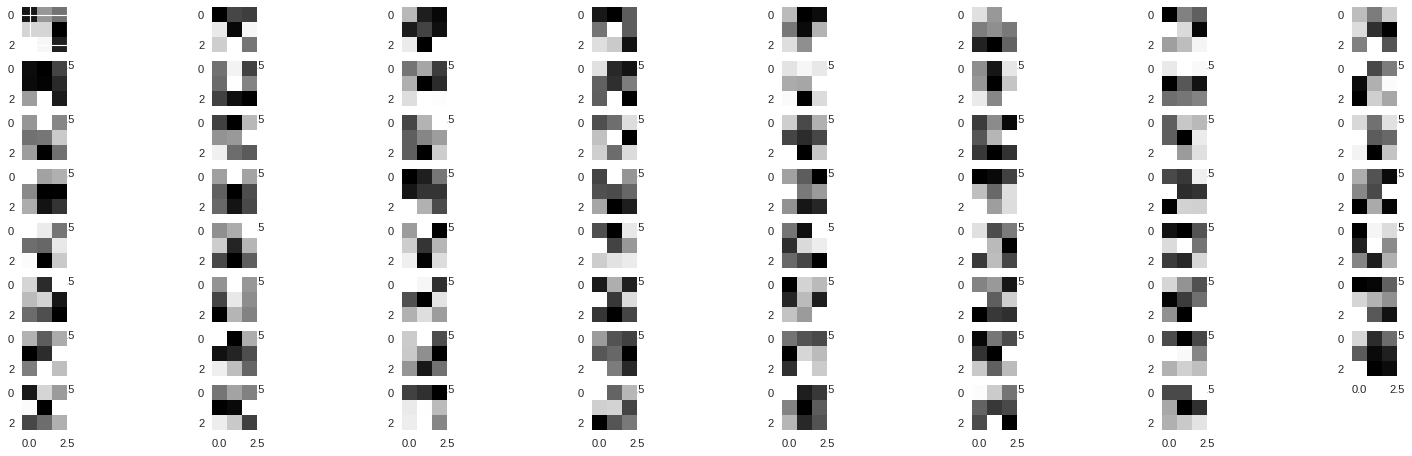

In [20]:
x1w = model_1_final_dropout.get_weights()[0][:,:,0,:]
plt.figure(num=None, figsize=(24, 7), dpi=80, facecolor='w', edgecolor='k')
for i in range(1,64):
    plt.subplot(8,8,i)
    plt.rcParams["axes.grid"] = False
    plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()

In [29]:
model_1_final_dropout.get_weights()[0]

array([[[[ 0.08131658, -0.02094249, -0.0979685 , ...,  0.11125892,
           0.11954423, -0.0580052 ],
         [-0.08705568,  0.07223941, -0.03955368, ...,  0.0529523 ,
          -0.06593585,  0.11528585],
         [-0.12325063,  0.00253365,  0.02559116, ...,  0.08199083,
          -0.11495171,  0.07511052]],

        [[-0.07251285,  0.04469188, -0.0555799 , ..., -0.04750955,
           0.07741275, -0.05790142],
         [ 0.04078412, -0.1157391 ,  0.06137915, ..., -0.08373756,
           0.04305441, -0.11021731],
         [-0.14588468, -0.13176177, -0.02458073, ...,  0.00981717,
           0.04794208, -0.07331321]],

        [[ 0.01676415,  0.02619366, -0.06047977, ..., -0.02877211,
           0.00394579,  0.06480166],
         [-0.09956416,  0.00773123,  0.07745602, ...,  0.03796833,
          -0.00599959,  0.10795823],
         [-0.11563186, -0.07892614,  0.03649147, ...,  0.0157012 ,
          -0.05659911, -0.0568142 ]]],


       [[[-0.0590358 ,  0.07648748,  0.0420285 , ...,  0